### 2020 June 7 ICME event


In [3]:
import sys
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import LightSource
from matplotlib.colors import ListedColormap
from matplotlib import rc

import numpy as np
from datetime import timedelta
import time
import pickle
import seaborn as sns
import os
import urllib
import json
import warnings
import importlib
import multiprocessing

import astropy
import astropy.constants as const
import astropy.units as unit
from astropy.coordinates import SkyCoord


import sunpy
import sunpy.time
from sunpy.time import parse_time

import heliopy.spice as spice
import heliopy.data.spice as spicedata

from sunpy.coordinates import frames

import py3dcore
import heliosat


#Convert this notebook to a script with jupyter nbconvert --to script cme_rate.ipynb
#os.system('jupyter nbconvert --to script psp_3dcore.ipynb')    

#%matplotlib inline
#matplotlib.use('Qt5Agg')
#matplotlib.use('Agg')
#warnings.filterwarnings('ignore') # some numpy mean-of-empty-slice runtime warnings

########### make directories first time
resdir='results'
if os.path.isdir(resdir) == False: os.mkdir(resdir)

datadir='data'
if os.path.isdir(datadir) == False: os.mkdir(datadir)

outputdirectory='results/plots'
if os.path.isdir(outputdirectory) == False: os.mkdir(outputdirectory)
    
    
animdirectory='results/animations_june7'
if os.path.isdir(animdirectory) == False: os.mkdir(animdirectory)
    
#rc('text', usetex=True)
#matplotlib.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}']


#--------------------- load solar orbiter data (made with heliocats)
filemag='data/mag/solo_2020_june_october_rtn.p'
sm=pickle.load(open(filemag, "rb" ) ) 


#--------------------- load Wind data
filewin='data/wind_2018_now_gse.p'
[win,hwin]=pickle.load(open(filewin, "rb" ) )

#set wind awkward data points to nan
windspike_ind=np.where(win.time > parse_time('2020-04-20 17:08').datetime)[0]
win.bt[windspike_ind[0:2]]=np.nan
win.bx[windspike_ind[0:2]]=np.nan
win.by[windspike_ind[0:2]]=np.nan
win.bz[windspike_ind[0:2]]=np.nan


#set wind awkward data points to nan
windspike_ind=np.where(win.time > parse_time('2020-04-21 01:20').datetime)[0]
win.bt[windspike_ind[0:1]]=np.nan
win.bx[windspike_ind[0:1]]=np.nan
win.by[windspike_ind[0:1]]=np.nan
win.bz[windspike_ind[0:1]]=np.nan


#cut out data around event from wind data time series
windbegin_ind=np.where(win.time > parse_time('2020-04-15 00:00').datetime)[0][0]
windend_ind=np.where(win.time > parse_time('2020-04-22 00:00').datetime)[0][0]
win=win[windbegin_ind:windend_ind]

#------------------------- load position data

#load position data (made with heliocats)
#[psp, bepi, solo, sta, earth, venus, mars, mercury,frame]= \
#      pickle.load( open( 'data/positions_psp_solo_bepi_sta_planets_HEEQ_1hour.p', "rb" ))

#load position data (made with heliocats)
[psp, bepi, solo, earth, mars, mercury,venus,sta,stb]= \
      pickle.load( open( 'data/positions_HCI_1hr.p', "rb" ))

#these are 1 minute HCI positions for the April May 2020 time range
#[psp, bepi, solo, earth, mars, mercury,venus,sta]= \
#      pickle.load( open( 'data/positions_HCI_1minute.p', "rb" ))


#convert to mdates
psp_numtime=mdates.date2num(psp.time)
bepi_numtime=mdates.date2num(bepi.time)
solo_numtime=mdates.date2num(solo.time)
sta_numtime=mdates.date2num(sta.time)
earth_numtime=mdates.date2num(earth.time)




#convert to mdates
#psp_numtime=psp.time+mdates.date2num(np.datetime64('0000-12-31')) 
#bepi_numtime=bepi.time+mdates.date2num(np.datetime64('0000-12-31'))
#solo_numtime=solo.time+mdates.date2num(np.datetime64('0000-12-31'))
#sta_numtime=sta.time+mdates.date2num(np.datetime64('0000-12-31'))
#earth_numtime=earth.time+mdates.date2num(np.datetime64('0000-12-31'))

#new_ordinal = old_ordinal+ mdates.date2num(np.datetime64('0000-12-31')) 



print('done')

In [6]:
class SOLO_EXTRA_APRIL(heliosat.SOLO):
    def get_data_raw(self, range_start, range_end, data_key, **kwargs):
        logger = logging.getLogger(__name__)
        data_key = self.resolve_data_key(data_key)
        range_start = sanitize_datetimes(range_start)
        range_end = sanitize_datetimes(range_end)
        frame = kwargs.get("frame", None)
        frame_cadence = kwargs.get("frame_cadence", None)
        force_download = kwargs.get("force_download", False)
        _data = pickle.load(open("/nas/helio/data/insitu_python/solo_2020_june_july_rtn.p", "rb"))
        time_all = np.array([_[0].replace(tzinfo=datetime.timezone.utc) for _ in _data])
        data_all = np.array([[_[1], _[2], _[3]] for _ in _data]).astype(np.float64)
        tfilter = (time_all > range_start) & (time_all < range_end)
        time_all = time_all[tfilter]
        data_all = data_all[tfilter]
        time_all = np.array([_.timestamp() for _ in time_all])
        return time_all, data_all
    

In [14]:
############### Model Settings
#t_launch = datetime.datetime(2020, 4, 15, 4)

#get model parameters from ABC fit analysis

#obj = py3dcore.abc.smc.ABCSMC()


#obj = py3dcore.fitting.ABCSMC()
obj = py3dcore.fitting.BaseFitter()
#obj.load('data/davies_2020/SOLO_APRIL_DELTA2.p')
#obj.load('data/3dcore/JUNE_EVENT.npy')

obj.load('data/telloni_2021/09.npy')



#parameters are in obj.particles

#set launch time
t_launch=obj.t_launch

#get index of best fit 
best_fit_ind=np.argmin(obj.epses)

#convert direction if necessary
#lon_hci=np.mean(obj.particles[:,1])
#lat_hci=np.mean(obj.particles[:,2])
#set coordinates as HCI
#direction_hci = SkyCoord(lon_hci*unit.deg, lat_hci*unit.deg, frame=frames.HeliocentricInertial,obstime=t_launch)
# convert HCI longitude latitude to HEEQ = HeliographicStonyhurst 
#direction_heeq=direction_hci.transform_to(frames.HeliographicStonyhurst)


#get parameters from mean
iparams_arr_mean = np.array([[
    np.mean(obj.particles[:,0]),      # time offset
    np.mean(obj.particles[:,1]),    # l_1 (longitude) *********************
    np.mean(obj.particles[:,2]),    # l_2 (latitude)
    np.mean(obj.particles[:,3]),      # o (inclination, orientation)
    np.mean(obj.particles[:,4]),   # d_1au (frontal width at 1AU)
    np.mean(obj.particles[:,5]),   # delta (cross-section aspect ratio)
    np.mean(obj.particles[:,6]),      # r_0 (initialization distance in solar radii)
    np.mean(obj.particles[:,7]),    # v_0 (initial velocty in)
    np.mean(obj.particles[:,8]),      # tau (magnetic field twist)
    np.mean(obj.particles[:,9]),      # b_s (magnetic field scaling parameter)
    np.mean(obj.particles[:,10]),     #  b_1au (magnetic field strength at 1au)
    np.mean(obj.particles[:,11]),    # Gamma (solar wind drag coefficient)
    np.mean(obj.particles[:,12]),    # v_sw (solar wind speed)
    0,#np.mean(obj.particles[:,13])
]], dtype=np.float32)


#get parameters from best fit (prefereed)
iparams_arr = np.array([[
    obj.particles[best_fit_ind,0],      # time offset
    obj.particles[best_fit_ind,1],    # l_1 (longitude) *********************
    obj.particles[best_fit_ind,2],    # l_2 (latitude)
    obj.particles[best_fit_ind,3],      # o (inclination, orientation)
    obj.particles[best_fit_ind,4],   # d_1au (frontal width at 1AU)
    obj.particles[best_fit_ind,5],   # delta (cross-section aspect ratio)
    obj.particles[best_fit_ind,6],      # r_0 (initialization distance in solar radii)
    obj.particles[best_fit_ind,7],    # v_0 (initial velocty in)
    obj.particles[best_fit_ind,8],      # tau (magnetic field twist)
    obj.particles[best_fit_ind,9],      # b_s (magnetic field scaling parameter)
    obj.particles[best_fit_ind,10],     #  b_1au (magnetic field strength at 1au)
    obj.particles[best_fit_ind,11],    # Gamma (solar wind drag coefficient)
    obj.particles[best_fit_ind,12],    # v_sw (solar wind speed)
    0,#np.mean(obj.particles[:,13])
]], dtype=np.float32)



model_obj = py3dcore.models.ThinTorusGH3DCOREModel(t_launch, runs=1, use_gpu=False)
model_obj.update_iparams(iparams_arr, seed=42)

#generic 3DCORE parameters, no fit
#iparams_arr2 = np.array([[
#    0,      # time offset
#    0,    # l_1 (longitude)
#    0,    # l_2 (latitude)
#    0,      # o (inclination, orientation)
#    0.20,   # d_1au (frontal width at 1AU)
#    4,   # delta (cross-section aspect ratio)
#    5,      # r_0 (initialization distance in solar radii)
#    350,    # v_0 (initial velocty in)
#    -2,      # tau (magnetic field twist)
#    1,      # b_s (magnetic field scaling parameter)
#    15,     #  b_1au (magnetic field strength at 1au)
#    1.5,    # Gamma (solar wind drag coefficient)
#    300,    # v_sw (solar wind speed)
#    0       # sigma (measurement noise)
#]], dtype=np.float32)


param_strings=['time offset', 'longitude', 'latitude', 'inclination', 'd_1au','width ratio', 'delta (cross-section aspect ratio)', 'r_0 launch radius (R_sun)', 'v_0 launch velocity (km/s)',  'tau (magnetic field twist)','n_a diameter expansion exponent','n_b magnetic field scaling exponent)', 'b_1au (magnetic field strength at 1au)',  'Gamma (solar wind drag coefficient)', 'v_sw (solar wind speed)', 'sigma (measurement noise)']


TP_A =  t_launch + datetime.timedelta(hours=24)
TP_B =  t_launch + datetime.timedelta(hours=120)

C_A = "xkcd:red"
C_B = "xkcd:blue"

C0 = "xkcd:black"
C1 = "xkcd:magenta"
C2 = "xkcd:orange"
C3 = "xkcd:azure"



earth_color='blue'
solo_color='orange'
venus_color='mediumseagreen'
mercury_color='grey'
psp_color='black'
sta_color='red'
bepi_color='coral'



print('3DCORE parameters in HCI')
for i in np.arange(0,14):     
    print(np.round(iparams_arr[0,i],3),param_strings[i])
    

3DCORE parameters in HCI
0.0 time offset
273.473 longitude
12.784 latitude
170.791 inclination
0.276 d_1au
0.634 width ratio
1.597 delta (cross-section aspect ratio)
20.0 r_0 launch radius (R_sun)
931.434 v_0 launch velocity (km/s)
20.455 tau (magnetic field twist)
1.14 n_a diameter expansion exponent
1.64 n_b magnetic field scaling exponent)
21.861 b_1au (magnetic field strength at 1au)
0.0 Gamma (solar wind drag coefficient)


### functions 

In [15]:
def measure(obj, sat, t0, t1, frame="HEEQ", bframe="HEEQ", satparams=None):
    if satparams:
        inst = getattr(heliosat, sat)(satparams)
    else:
        inst = getattr(heliosat, sat)()

    #time resolution in seconds
    #t_s = [datetime.datetime.fromtimestamp(_) for _ in np.array(list(range(int(t0.timestamp()), int(t1.timestamp()))))]
    
    #time resolution in minutes
    res_in_days=1/(24*60.)    
    t_s = []
    while t0 < t1:
        t_s.append(t0)
        t0 += timedelta(days=res_in_days)

    #print('data points',len(t_s))
    
    
    o_s = inst.trajectory(t_s, frame=frame)

    if satparams:
        b = heliosat.spice.transform_frame([satparams] * len(t_s), np.array(obj.sim_fields(t_s, o_s))[:, 0, :], frame, bframe)
    else:
        b = heliosat.spice.transform_frame(t_s, np.array(obj.sim_fields(t_s, o_s))[:, 0, :], frame, bframe)

    b[b == 0] = np.nan

    return t_s, np.sqrt(np.sum(b**2, axis=1)), b


#define sun here so it does not need to be recalculated every time
scale=695510/149597870.700*1 #Rs in km, AU in km
# sphere with radius Rs in AU
u, v = np.mgrid[0:2*np.pi:40j, 0:np.pi:30j]
x = np.cos(u)*np.sin(v)*scale
y = np.sin(u)*np.sin(v)*scale
z = np.cos(v)*scale



def plot_configure(ax, **kwargs):
    view_azim = kwargs.pop("view_azim", -25)
    view_elev = kwargs.pop("view_elev", 25)
    view_radius = kwargs.pop("view_radius", .5)
    
    ax.view_init(azim=view_azim, elev=view_elev)

    ax.set_xlim([-view_radius, view_radius])
    ax.set_ylim([-view_radius, view_radius])
    #adjust scaling as matplotlib lacks automatic aspect ratio setting
    ax.set_zlim([-view_radius*0.75, view_radius*0.75])    

    
    #solar equatorial plane
    #for p in np.arange(-2,2,0.2):
    #    ax.plot([-2,2],[p,p],[0,0],lw=0.5,color='black', alpha=0.2,linestyle='--',zorder=0 )
    #    ax.plot([p,p],[-2,2],[0,0],lw=0.5,color='black', alpha=0.2,linestyle='--',zorder=0 )
    
    #draw sun        
    ls = LightSource(azdeg=140, altdeg=40)  
    ax.plot_surface(x, y, z, rstride=1, cstride=1, color='yellow',lightsource=ls, linewidth=0, antialiased=False,zorder=5)

    p=np.arange(0,2*np.pi,0.01)
    r1=1.0
    ax1.plot(r1*np.sin(p),r1*np.cos(p),0,lw=0.5,color='black', alpha=0.5,linestyle='--',zorder=0 )
    r1=0.8
    ax1.plot(r1*np.sin(p),r1*np.cos(p),0,lw=0.5,color='black', alpha=0.5,linestyle='--',zorder=0 )
    r1=0.6
    ax1.plot(r1*np.sin(p),r1*np.cos(p),0,lw=0.5,color='black', alpha=0.5,linestyle='--',zorder=0 )
    r1=0.4
    ax1.plot(r1*np.sin(p),r1*np.cos(p),0,lw=0.5,color='black', alpha=0.5,linestyle='--',zorder=0 )
    r1=0.2
    ax1.plot(r1*np.sin(p),r1*np.cos(p),0,lw=0.5,color='black', alpha=0.5,linestyle='--',zorder=0 )
    
    
    ax.set_axis_off()

def plot_3dcore(ax, obj, t_snap, **kwargs):
    kwargs["alpha"] = kwargs.pop("alpha", .12)
    kwargs["color"] = kwargs.pop("color", "k")
    kwargs["lw"] = kwargs.pop("lw", 1)  

    model_obj.propagate(t_snap)
    wf_model = model_obj.visualize_wireframe(index=0)
    ax.plot_wireframe(*wf_model.T, **kwargs,zorder=3)    
    
   
   
def plot_3dcore_field(ax, obj, step_size=0.005, q0=[1, .1, np.pi/2],**kwargs):

    #initial point is q0
    q0i =np.array(q0, dtype=np.float32).astype(np.float32)    
    fl = model_obj.visualize_fieldline_dpsi(q0i, dpsi=2*np.pi-0.01, step_size=step_size)
    ax.plot(*fl.T, **kwargs)
    

def plot_traj(ax, sat, t_snap, frame="HEEQ", traj_pos=True, traj_major=4, traj_minor=None, **kwargs):
    kwargs["alpha"] = kwargs.pop("alpha", 1)
    kwargs["color"] = kwargs.pop("color", "k")
    kwargs["lw"] = kwargs.pop("lw", 1)
    kwargs["s"] = kwargs.pop("s", 25)
    
    inst = getattr(heliosat, sat)()

    _s = kwargs.pop("s")

    if traj_pos:
        pos = inst.trajectory(t_snap, frame)

        ax.scatter(*pos.T, s=_s, **kwargs)
        
    if traj_major and traj_major > 0:
        traj = inst.trajectory([t_snap + datetime.timedelta(hours=i) for i in range(-traj_major, traj_major)], frame)
        #ax.plot(*traj.T, **kwargs)
        
    if traj_minor and traj_minor > 0:
        traj = inst.trajectory([t_snap + datetime.timedelta(hours=i) for i in range(-traj_minor, traj_minor)], frame)
        
        if "ls" in kwargs:
            kwargs.pop("ls")

        _ls = "--"
        _lw = kwargs.pop("lw") / 2
        
        ax.plot(*traj.T, ls=_ls, lw=_lw, **kwargs)

        
        
def plot_shift(axis,extent,cx,cy,cz):
    #shift center of plot
    axis.set_xbound(cx-extent, cx+extent)
    axis.set_ybound(cy-extent, cy+extent)
    axis.set_zbound(cz-extent*0.75, cz+extent*0.75)  
    
  

### measure fields

In [16]:
#t1, btot1, bxyz1 = measure(model_obj, "PSP",  t_launch, TP_A  + datetime.timedelta(hours=6), frame="HEEQ", bframe="HEEQ")
#t2, btot2, bxyz2 = measure(model_obj, "PSP",  t_launch, tlist[k]  + datetime.timedelta(hours=12), frame="HEEQ", bframe="HEEQ")
t1, btot1, bxyz1 = measure(model_obj, "SOLO", t_launch, TP_B  + datetime.timedelta(hours=96), frame="HCI", bframe="SOLO_SUN_RTN")
#t2, btot2, bxyz2 = measure(model_obj, "Earth", t_launch, TP_B  + datetime.timedelta(hours=96), frame="HCI", bframe="HEE")


fileout='june_2020_3dcore_fit_solo.p'      
pickle.dump([t1,btot1,bxyz1,model_obj], open('data/'+fileout, "wb"))

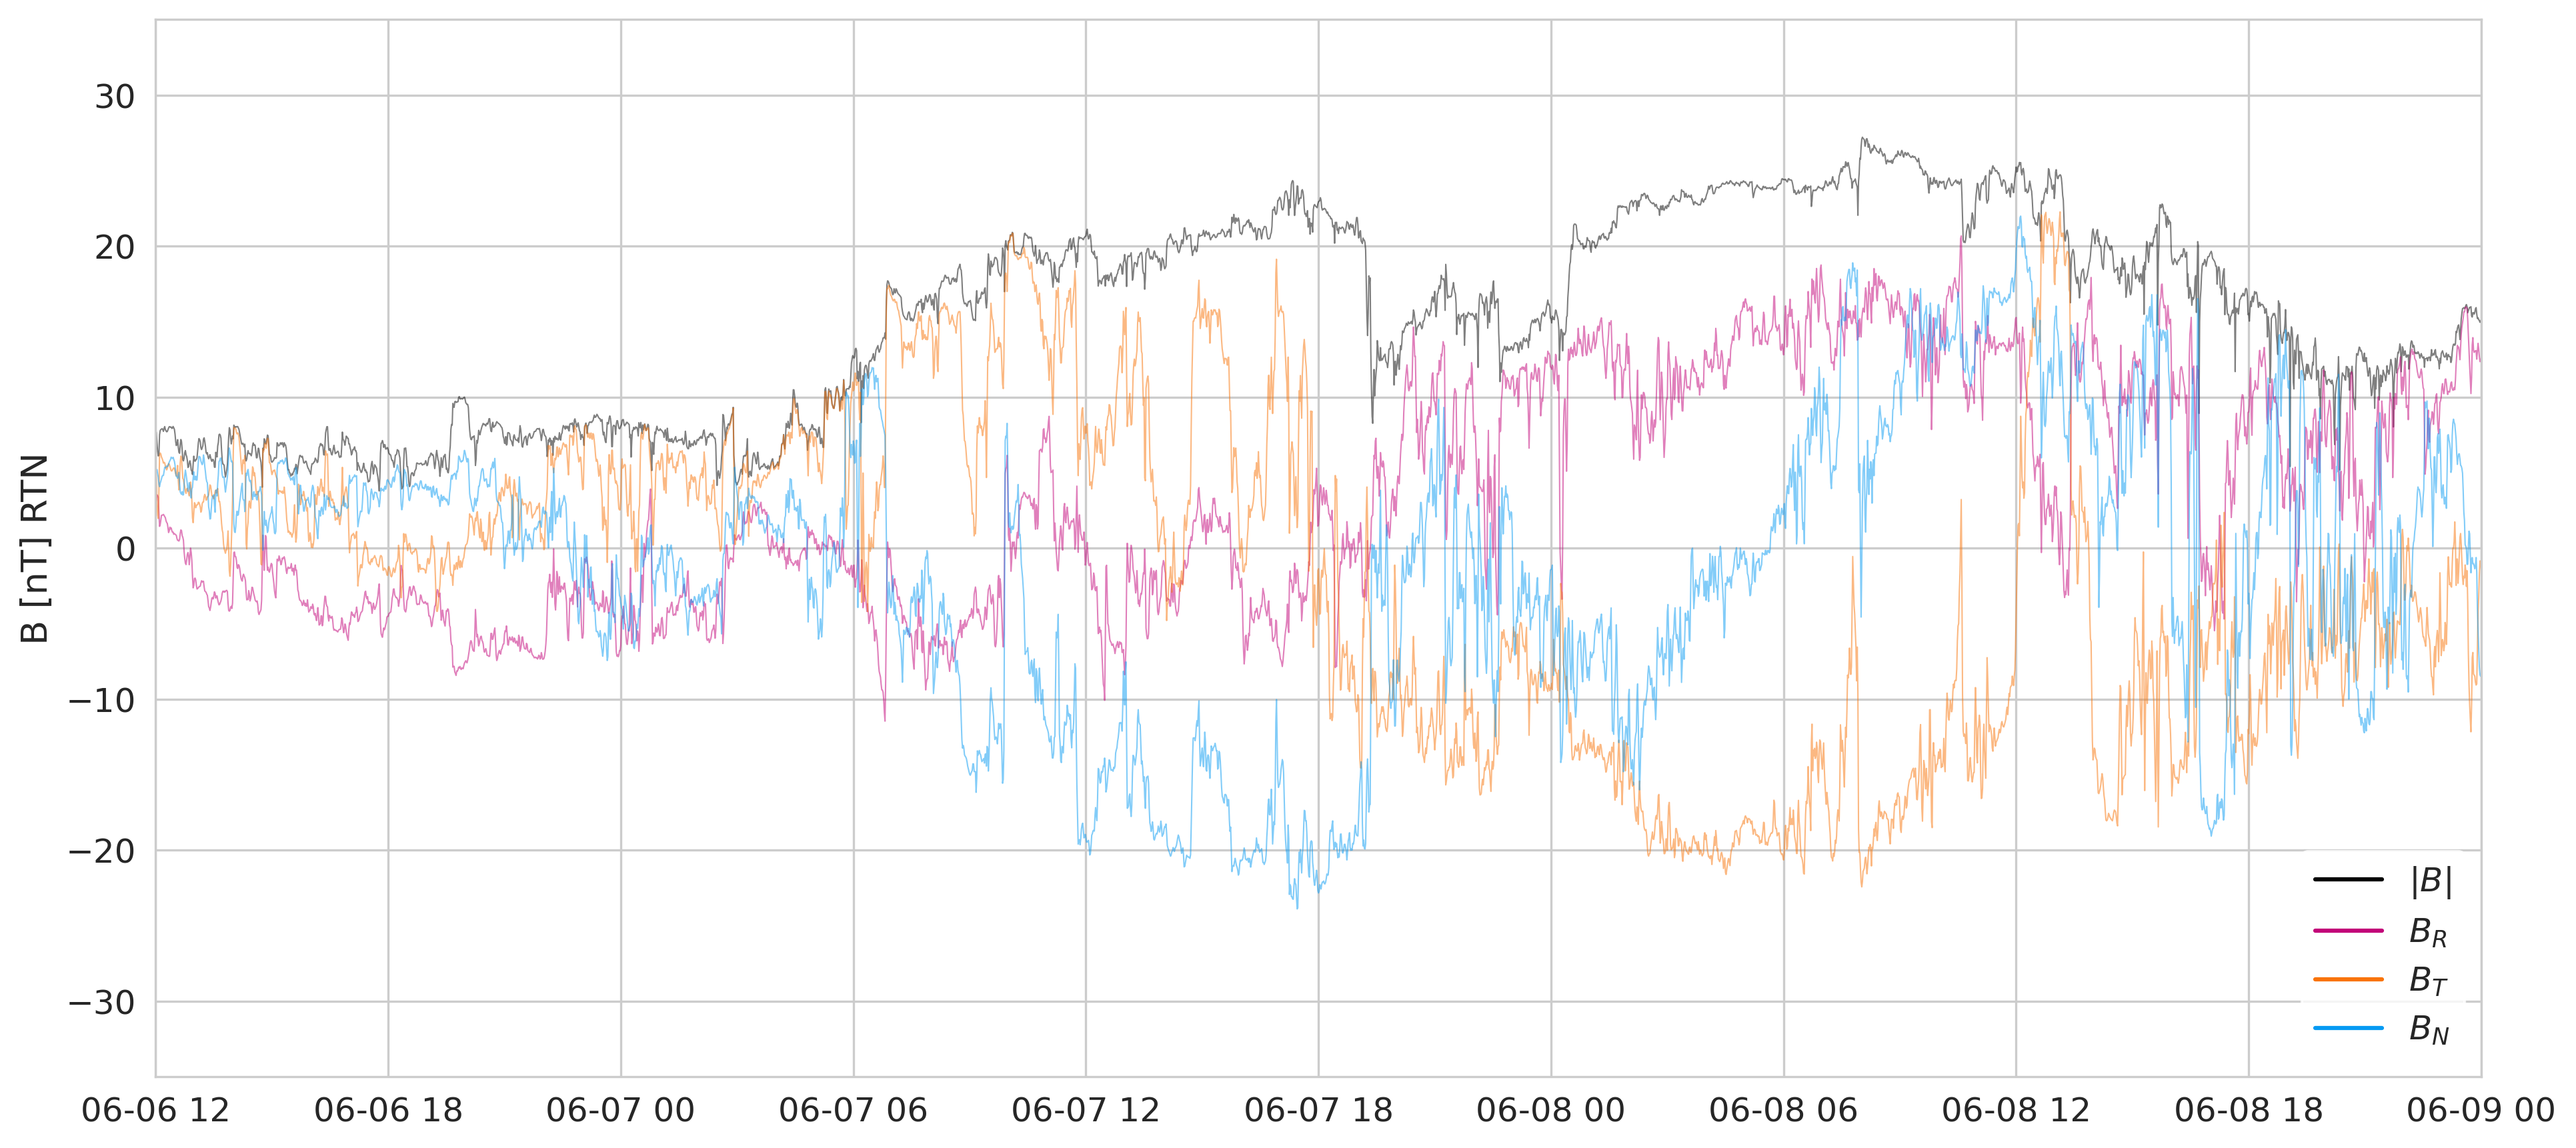

In [17]:
%matplotlib inline
sns.set_style('whitegrid')
fig = plt.figure(1,figsize=(15, 7),dpi=300)

#define subplot grid
ax1 = plt.subplot2grid((1, 1), (0, 0))  

setalpha=0.5

ax1.plot(t1, btot1, color=C0, label="$|B|$")
ax1.plot(t1, bxyz1[:, 0], color=C1, label="$B_R$")
ax1.plot(t1, bxyz1[:, 1], color=C2, label="$B_T$")
ax1.plot(t1, bxyz1[:, 2], color=C3, label="$B_N$")
ax1.plot(sm.time, sm.bt, color=C0,lw=0.5,alpha=setalpha)
ax1.plot(sm.time, sm.bx, color=C1,lw=0.5,alpha=setalpha)
ax1.plot(sm.time, sm.by, color=C2,lw=0.5,alpha=setalpha)
ax1.plot(sm.time, sm.bz, color=C3,lw=0.5,alpha=setalpha)


ax1.legend(loc="lower right", fontsize=12,ncol=1,edgecolor='white')
#ax4.set_ylabel('Solar Orbiter B [nT] RTN')
ax1.set_ylabel('B [nT] RTN',fontsize=13)
ax1.set_xlim(datetime.datetime(2020,6,6,12,0),datetime.datetime(2020,6,9,0,0))
ax1.set_ylim(-35,35)

ax1.tick_params(labelsize=12)



plot_res=pickle.load(open('data/'+fileout,'rb'))


#erste spalte ist zeit, dann mean_xyz, max_xyz, min_xyz
#ax1.fill_between(plot_res[0,:], plot_res[4,:],plot_res[7,:], alpha=0.1)



#meanx=(plot_res[1,:]).astype(float)
#minx=(plot_res[7,:]).astype(float)
#maxx=(plot_res[4,:]).astype(float)

#meany=(plot_res[2,:]).astype(float)
#miny=(plot_res[8,:]).astype(float)
#maxy=(plot_res[5,:]).astype(float)

#meanz=(plot_res[3,:]).astype(float)
#minz=(plot_res[9,:]).astype(float)
#maxz=(plot_res[6,:]).astype(float)


#plt.plot( plot_res[0,:],meanx,color=C1,ls='--')
#plt.plot( plot_res[0,:],meany,color=C2,ls='--')
#plt.plot( plot_res[0,:],meanz,color=C3,ls='--')


#
#plt.fill_between(plot_res[0,:], minx,maxx, alpha=0.1,color=C1)
#plt.fill_between(plot_res[0,:], miny,maxy, alpha=0.1,color=C2)
#plt.fill_between(plot_res[0,:], minz,maxz, alpha=0.1,color=C3)



#interval
#datetime.datetime(2020, 4, 19, 10, 55, tzi

plt.savefig('results/plots/fit_insitu_june7_2020.pdf',bbox_inches='tight')
plt.savefig('results/plots/fit_insitu_june7_2020.png', dpi=200)#,bbox_inches='tight')



### simple position plot

current frame_time_num 2020-06-07 00:00:00+00:00


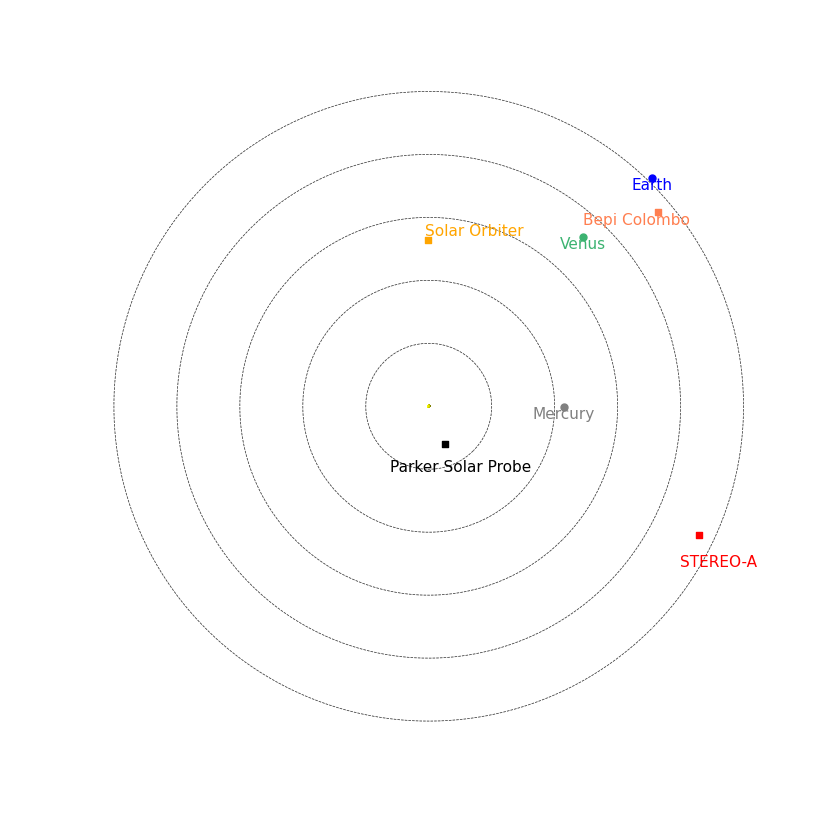

In [14]:


sns.set_style('whitegrid')
fig = plt.figure(1,figsize=(19.2, 10.8),dpi=100)

#define subplot grid
ax1 = plt.subplot2grid((1, 1), (0, 0),projection='3d')  

######### tilted view
plot_configure(ax1, view_azim=40, view_elev=90, view_radius=.8)

#impact time of CME at solar orbiter 
ti = datetime.datetime(2020, 6, 7, 0,0,0)

#plot_3dcore(ax1, model_obj, TP_B, color=C_B)
#plot_3dcore_field(ax1, model_obj, color=C_A, steps=400, step_size=0.0005, lw=1.0, ls="-")
plot_traj(ax1, "Earth", ti, frame="HCI", color=earth_color)
plot_traj(ax1, "Venus", ti, frame="HCI", color=venus_color)
plot_traj(ax1, "Mercury", ti, frame="HCI", color=mercury_color)
plot_traj(ax1, "SOLO", ti, frame="HCI", color=solo_color,marker='s')
plot_traj(ax1, "PSP", ti, frame="HCI", color=psp_color,marker='s')
plot_traj(ax1, "STA", ti, frame="HCI", color=sta_color,marker='s')
plot_traj(ax1, "BEPI", ti, frame="HCI", color=bepi_color,marker='s')


frame_time_num=mdates.date2num(ti) 
print( 'current frame_time_num', str(mdates.num2date(frame_time_num)))

#these have their own times
dct=frame_time_num-psp_numtime
psp_timeind=np.argmin(abs(dct))

dct=frame_time_num-bepi_numtime
bepi_timeind=np.argmin(abs(dct))

dct=frame_time_num-solo_numtime
solo_timeind=np.argmin(abs(dct))

dct=frame_time_num-sta_numtime
sta_timeind=np.argmin(abs(dct))

#all same times
dct=frame_time_num-earth_numtime
earth_timeind=np.argmin(abs(dct))


fsize=15


#planet and spacecraft labels

ax1.text(earth.x[earth_timeind],earth.y[earth_timeind],earth.z[earth_timeind],'Earth', color=earth_color, ha='center',fontsize=fsize-4,verticalalignment='top')
ax1.text(venus.x[earth_timeind],venus.y[earth_timeind],venus.z[earth_timeind],'Venus', color=venus_color, ha='center',fontsize=fsize-4,verticalalignment='top')
ax1.text(mercury.x[earth_timeind],mercury.y[earth_timeind],mercury.z[earth_timeind],'Mercury', color=mercury_color, ha='center',fontsize=fsize-4,verticalalignment='top')

ax1.text(psp.x[psp_timeind],psp.y[psp_timeind]+0.07,psp.z[psp_timeind],'Parker Solar Probe', color=psp_color, ha='center',fontsize=fsize-4,verticalalignment='top')
ax1.text(solo.x[solo_timeind]-0.15,solo.y[solo_timeind]+0.07,solo.z[solo_timeind],'Solar Orbiter', color=solo_color, ha='center',fontsize=fsize-4,verticalalignment='top')
ax1.text(bepi.x[bepi_timeind]+0.05,bepi.y[bepi_timeind]-0.05,bepi.z[bepi_timeind],'Bepi Colombo', color=bepi_color, ha='center',fontsize=fsize-4,verticalalignment='top')
ax1.text(sta.x[sta_timeind],sta.y[sta_timeind]+0.09,sta.z[sta_timeind],'STEREO-A', color=sta_color, ha='center',fontsize=fsize-4,verticalalignment='top')

#1 AU circle
p=np.arange(0,2*np.pi,0.01)
r1=1.0
ax1.plot(r1*np.sin(p),r1*np.cos(p),0,lw=0.5,color='black', alpha=0.5,linestyle='--',zorder=0 )
r1=0.8
ax1.plot(r1*np.sin(p),r1*np.cos(p),0,lw=0.5,color='black', alpha=0.5,linestyle='--',zorder=0 )
r1=0.6
ax1.plot(r1*np.sin(p),r1*np.cos(p),0,lw=0.5,color='black', alpha=0.5,linestyle='--',zorder=0 )
r1=0.4
ax1.plot(r1*np.sin(p),r1*np.cos(p),0,lw=0.5,color='black', alpha=0.5,linestyle='--',zorder=0 )
r1=0.2
ax1.plot(r1*np.sin(p),r1*np.cos(p),0,lw=0.5,color='black', alpha=0.5,linestyle='--',zorder=0 )


#a_circle = plt.Circle((0, 0), 1.1,fill=False,zorder=3,linestyle='-')
#ax1.add_artist(a_circle)
plt.savefig('results/plots/positions_solo_apr2020_event_hci.png', dpi=100,bbox_inches='tight')

#plt.savefig('results/plots/positions_solo_apr2020_event_tilt.png', dpi=100,bbox_inches='tight')

## model plot 
 


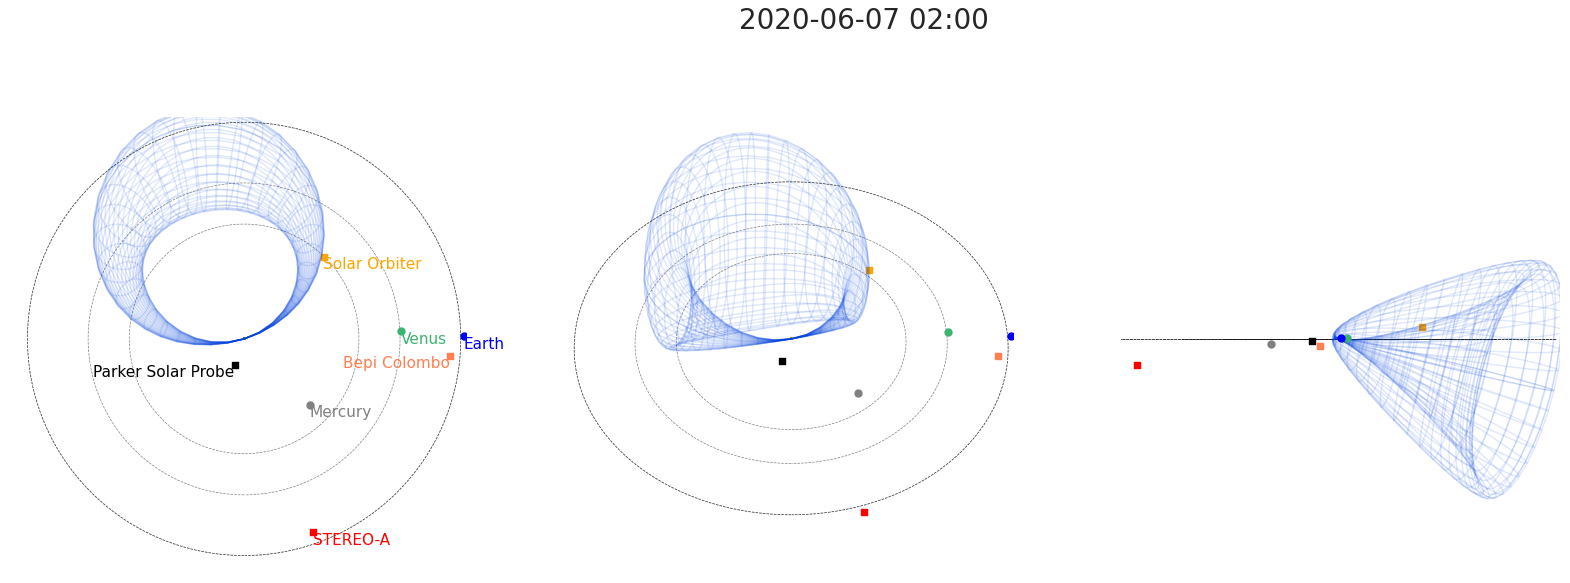

In [15]:
#define sun here so it does not need to be recalculated every time
scale=695510/149597870.700*1 #Rs in km, AU in km
# sphere with radius Rs in AU
u, v = np.mgrid[0:2*np.pi:40j, 0:np.pi:30j]
x = np.cos(u)*np.sin(v)*scale
y = np.sin(u)*np.sin(v)*scale
z = np.cos(v)*scale



def plot_configure2(ax, **kwargs):
    view_azim = kwargs.pop("view_azim", -25)
    view_elev = kwargs.pop("view_elev", 25)
    view_radius = kwargs.pop("view_radius", .5)
    
    ax.view_init(azim=view_azim, elev=view_elev)

    ax.set_xlim([-view_radius, view_radius])
    ax.set_ylim([-view_radius, view_radius])
    #adjust scaling as matplotlib lacks automatic aspect ratio setting
    ax.set_zlim([-view_radius*0.75, view_radius*0.75])    

    
    #solar equatorial plane
    #for p in np.arange(-2,2,0.2):
    #    ax.plot([-2,2],[p,p],[0,0],lw=0.5,color='black', alpha=0.2,linestyle='--',zorder=0 )
    #    ax.plot([p,p],[-2,2],[0,0],lw=0.5,color='black', alpha=0.2,linestyle='--',zorder=0 )
    
    #draw sun        
    ls = LightSource(azdeg=0, altdeg=40)  
    ax.plot_surface(x, y, z, rstride=1, cstride=1, color='yellow',lightsource=ls, linewidth=0, antialiased=False,zorder=5)
    
    #1 AU circle
    p=np.arange(0,2*np.pi,0.01)
    r1=1.0
    ax.plot(r1*np.sin(p),r1*np.cos(p),0,lw=0.5,color='black', alpha=0.5,linestyle='--',zorder=0 )
    r2=0.72
    ax.plot(r2*np.sin(p),r2*np.cos(p),0,lw=0.5,color='black', alpha=0.5,linestyle='--',zorder=0 )
    r2=0.53
    ax.plot(r2*np.sin(p),r2*np.cos(p),0,lw=0.5,color='black', alpha=0.5,linestyle='--',zorder=0 )

    #ax.plot(r1*np.sin(p),r1*np.cos(p),0,lw=0.5,color='black', alpha=0.5,linestyle='--',zorder=0 )
    #ax.plot(r1*np.sin(p),r1*np.cos(p),0,lw=0.5,color='black', alpha=0.5,linestyle='--',zorder=0 )


    
    ax.set_axis_off()


    

#for field line plots stepsize and initial point for drawing    
field_stepsize=0.001    
q1=np.array([1, .1, np.pi/2])

sns.set_style('whitegrid')
fig = plt.figure(1,figsize=(20, 7),dpi=100)

#define subplot grid
ax1 = plt.subplot2grid((1, 3), (0, 0),projection='3d')  
ax2 = plt.subplot2grid((1, 3), (0, 1),projection='3d')  
ax3 = plt.subplot2grid((1, 3), (0, 2),projection='3d')  
#ax4 = plt.subplot2grid((4, 3), (2, 0))  
#ax5 = plt.subplot2grid((4, 3), (3, 0))  
#ax6 = plt.subplot2grid((4, 3), (3, 1))  
#ax7 = plt.subplot2grid((4, 3), (3, 2))  


#manually set axes positions
#https://matplotlib.org/api/_as_gen/matplotlib.axes.Axes.set_position.html#matplotlib.axes.Axes.set_position
#ax1.set_position([0,0.3,0.6,0.65], which='both')
#ax2.set_position([0.65,0.35,0.35,0.65], which='both')
#ax3.set_position([0.6,0,0.4,0.4], which='both')
#ax4.set_position([0.05,0.22,0.29,0.17], which='both')
#ax6.set_position([0.05,0.03,0.29,0.17], which='both')
#ax5.set_position([0.40,0.22,0.27,0.17], which='both')
#ax7.set_position([0.40,0.03,0.27,0.17], which='both')





########### top view panel
plot_configure2(ax1, view_azim=90, view_elev=90, view_radius=.65)
#plot_traj(ax2, "PSP", TP_B, frame="ECLIPJ2000", color="k", traj_pos=False, traj_major=None, traj_minor=144,lw=1.5)
plot_3dcore(ax1, model_obj, TP_B, color=C_B)
#plot_3dcore_field(ax2, model_obj, color=C_B, step_size=field_stepsize, lw=1.1, ls="-",q0=q1)

plot_traj(ax1, "Earth", TP_B, frame="HCI", color=earth_color)
plot_traj(ax1, "Venus", TP_B, frame="HCI", color=venus_color)
plot_traj(ax1, "Mercury", TP_B, frame="HCI", color=mercury_color)
plot_traj(ax1, "SOLO", TP_B, frame="HCI", color=solo_color,marker='s')
plot_traj(ax1, "PSP", TP_B, frame="HCI", color=psp_color,marker='s')
plot_traj(ax1, "STA", TP_B, frame="HCI", color=sta_color,marker='s')
plot_traj(ax1, "BEPI", TP_B, frame="HCI", color=bepi_color,marker='s')

#plot_shift(ax2,0.62,-0.2,0.2,0)




######### tilted view
plot_configure2(ax2, view_azim=90, view_elev=50, view_radius=.65)

plot_3dcore(ax2, model_obj, TP_B, color=C_B)
#plot_3dcore_field(ax1, model_obj, color=C_B, step_size=field_stepsize, lw=1.1, ls="-",q0=q1)
#plot_3dcore_field(ax1, model_obj, color=C_B, step_size=0.005, lw=1.1, ls="-",q0=np.array([0.5, .1, np.pi/2]))

plot_traj(ax2, "Earth", TP_B, frame="HCI", color=earth_color)
plot_traj(ax2, "Venus", TP_B, frame="HCI", color=venus_color)
plot_traj(ax2, "Mercury", TP_B, frame="HCI", color=mercury_color)
plot_traj(ax2, "SOLO", TP_B, frame="HCI", color=solo_color,marker='s')
plot_traj(ax2, "PSP", TP_B, frame="HCI", color=psp_color,marker='s')
plot_traj(ax2, "STA", TP_B, frame="HCI", color=sta_color,marker='s')
plot_traj(ax2, "BEPI", TP_B, frame="HCI", color=bepi_color,marker='s')

#plot_shift(ax1,0.3,-0.5,0.5,0)

############### edge on view panel
plot_configure2(ax3, view_azim=90+90, view_elev=0, view_radius=.65)
plot_3dcore(ax3, model_obj, TP_B, color=C_B)
#plot_3dcore_field(ax3, model_obj, color=C_B, step_size=field_stepsize, lw=1.1, ls="-",q0=q1)


plot_traj(ax3, "Earth", TP_B, frame="HCI", color=earth_color)
plot_traj(ax3, "Venus", TP_B, frame="HCI", color=venus_color)
plot_traj(ax3, "Mercury", TP_B, frame="HCI", color=mercury_color)
plot_traj(ax3, "SOLO", TP_B, frame="HCI", color=solo_color,marker='s')
plot_traj(ax3, "PSP", TP_B, frame="HCI", color=psp_color,marker='s')
plot_traj(ax3, "STA", TP_B, frame="HCI", color=sta_color,marker='s')
plot_traj(ax3, "BEPI", TP_B, frame="HCI", color=bepi_color,marker='s')

#plot_shift(ax3,0.4,-0.2,0.2,0)



#1 AU circle
p=np.arange(0,2*np.pi,0.01)
r1=1.0
ax1.plot(r1*np.sin(p),r1*np.cos(p),0,lw=0.5,color='black', alpha=0.5,linestyle='--',zorder=0 )
ax2.plot(r1*np.sin(p),r1*np.cos(p),0,lw=0.5,color='black', alpha=0.5,linestyle='--',zorder=0 )
ax3.plot(r1*np.sin(p),r1*np.cos(p),0,lw=0.5,color='black', alpha=0.5,linestyle='--',zorder=0 )


#panel labels
#plt.annotate('(a)',[0.00,0.93],xycoords='figure fraction',fontsize=20)
#plt.annotate('(b)',[0.69,0.93],xycoords='figure fraction',fontsize=20)
#plt.annotate('(c)',[0.69,0.32],xycoords='figure fraction',fontsize=20)
#plt.annotate('(d)',[0.00,0.32],xycoords='figure fraction',fontsize=20)
#plt.annotate('(e)',[0.345,0.32],xycoords='figure fraction',fontsize=20)



#current time
plt.annotate(parse_time(TP_B).iso[0:16],[0.55,0.95],ha='center',xycoords='figure fraction',fontsize=20)



#planet and spacecraft labels

ax1.text(earth.x[earth_timeind],earth.y[earth_timeind],earth.z[earth_timeind],'Earth', color=earth_color, ha='left',fontsize=fsize-4,verticalalignment='top')
ax1.text(solo.x[solo_timeind],solo.y[solo_timeind],solo.z[solo_timeind],'Solar Orbiter', color=solo_color, ha='left',fontsize=fsize-4,verticalalignment='top')
ax1.text(venus.x[earth_timeind],venus.y[earth_timeind],venus.z[earth_timeind],'Venus', color=venus_color, ha='left',fontsize=fsize-4,verticalalignment='top')
ax1.text(mercury.x[earth_timeind],mercury.y[earth_timeind],mercury.z[earth_timeind],'Mercury', color=mercury_color, ha='left',fontsize=fsize-4,verticalalignment='top')

ax1.text(psp.x[psp_timeind],psp.y[psp_timeind],psp.z[psp_timeind],'Parker Solar Probe', color=psp_color, ha='right',fontsize=fsize-4,verticalalignment='top')
ax1.text(bepi.x[bepi_timeind],bepi.y[bepi_timeind],bepi.z[bepi_timeind],'Bepi Colombo', color=bepi_color, ha='right',fontsize=fsize-4,verticalalignment='top')
ax1.text(sta.x[sta_timeind],sta.y[sta_timeind],sta.z[sta_timeind],'STEREO-A', color=sta_color, ha='left',fontsize=fsize-4,verticalalignment='top')




#plt.annotate(parse_time(t_launch).iso[0:16],[0.55,0.35],ha='center',xycoords='figure fraction',fontsize=20)
plt.savefig('results/plots/visual_june7_2020.pdf',bbox_inches='tight')
plt.savefig('results/plots/visual_june7_2020.png', dpi=200)#,bbox_inches='tight')


In [16]:
def make_frame(k):
    



    #for field line plots stepsize and initial point for drawing    
    field_stepsize=0.001    
    q1=np.array([1, .1, np.pi/2])

    sns.set_style('whitegrid')
    fig = plt.figure(1,figsize=(20, 7),dpi=100)

    #define subplot grid
    ax1 = plt.subplot2grid((1, 3), (0, 0),projection='3d')  
    ax2 = plt.subplot2grid((1, 3), (0, 1),projection='3d')  
    ax3 = plt.subplot2grid((1, 3), (0, 2),projection='3d')  
    #ax4 = plt.subplot2grid((4, 3), (2, 0))  
    #ax5 = plt.subplot2grid((4, 3), (3, 0))  
    #ax6 = plt.subplot2grid((4, 3), (3, 1))  
    #ax7 = plt.subplot2grid((4, 3), (3, 2))  


    #manually set axes positions
    #https://matplotlib.org/api/_as_gen/matplotlib.axes.Axes.set_position.html#matplotlib.axes.Axes.set_position
    #ax1.set_position([0,0.3,0.6,0.65], which='both')
    #ax2.set_position([0.65,0.35,0.35,0.65], which='both')
    #ax3.set_position([0.6,0,0.4,0.4], which='both')
    #ax4.set_position([0.05,0.22,0.29,0.17], which='both')
    #ax6.set_position([0.05,0.03,0.29,0.17], which='both')
    #ax5.set_position([0.40,0.22,0.27,0.17], which='both')
    #ax7.set_position([0.40,0.03,0.27,0.17], which='both')





    ########### top view panel
    plot_configure2(ax1, view_azim=90, view_elev=90, view_radius=.65)
    #plot_traj(ax2, "PSP", tlist[k], frame="ECLIPJ2000", color="k", traj_pos=False, traj_major=None, traj_minor=144,lw=1.5)
    plot_3dcore(ax1, model_obj, tlist[k], color=C_B)
    #plot_3dcore_field(ax2, model_obj, color=C_B, step_size=field_stepsize, lw=1.1, ls="-",q0=q1)

    plot_traj(ax1, "Earth", tlist[k], frame="HCI", color=earth_color)
    plot_traj(ax1, "Venus", tlist[k], frame="HCI", color=venus_color)
    plot_traj(ax1, "Mercury", tlist[k], frame="HCI", color=mercury_color)
    plot_traj(ax1, "SOLO", tlist[k], frame="HCI", color=solo_color,marker='s')
    plot_traj(ax1, "PSP", tlist[k], frame="HCI", color=psp_color,marker='s')
    plot_traj(ax1, "STA", tlist[k], frame="HCI", color=sta_color,marker='s')
    plot_traj(ax1, "BEPI", tlist[k], frame="HCI", color=bepi_color,marker='s')

    #plot_shift(ax2,0.62,-0.2,0.2,0)




    ######### tilted view
    plot_configure2(ax2, view_azim=90, view_elev=50, view_radius=.65)

    plot_3dcore(ax2, model_obj, tlist[k], color=C_B)
    #plot_3dcore_field(ax1, model_obj, color=C_B, step_size=field_stepsize, lw=1.1, ls="-",q0=q1)
    #plot_3dcore_field(ax1, model_obj, color=C_B, step_size=0.005, lw=1.1, ls="-",q0=np.array([0.5, .1, np.pi/2]))

    plot_traj(ax2, "Earth", tlist[k], frame="HCI", color=earth_color)
    plot_traj(ax2, "Venus", tlist[k], frame="HCI", color=venus_color)
    plot_traj(ax2, "Mercury", tlist[k], frame="HCI", color=mercury_color)
    plot_traj(ax2, "SOLO", tlist[k], frame="HCI", color=solo_color,marker='s')
    plot_traj(ax2, "PSP", tlist[k], frame="HCI", color=psp_color,marker='s')
    plot_traj(ax2, "STA", tlist[k], frame="HCI", color=sta_color,marker='s')
    plot_traj(ax2, "BEPI", tlist[k], frame="HCI", color=bepi_color,marker='s')

    #plot_shift(ax1,0.3,-0.5,0.5,0)

    ############### edge on view panel
    plot_configure2(ax3, view_azim=90+90, view_elev=0, view_radius=.65)
    plot_3dcore(ax3, model_obj, tlist[k], color=C_B)
    #plot_3dcore_field(ax3, model_obj, color=C_B, step_size=field_stepsize, lw=1.1, ls="-",q0=q1)


    plot_traj(ax3, "Earth", tlist[k], frame="HCI", color=earth_color)
    plot_traj(ax3, "Venus", tlist[k], frame="HCI", color=venus_color)
    plot_traj(ax3, "Mercury", tlist[k], frame="HCI", color=mercury_color)
    plot_traj(ax3, "SOLO", tlist[k], frame="HCI", color=solo_color,marker='s')
    plot_traj(ax3, "PSP", tlist[k], frame="HCI", color=psp_color,marker='s')
    plot_traj(ax3, "STA", tlist[k], frame="HCI", color=sta_color,marker='s')
    plot_traj(ax3, "BEPI", tlist[k], frame="HCI", color=bepi_color,marker='s')

    #plot_shift(ax3,0.4,-0.2,0.2,0)



    #1 AU circle
    p=np.arange(0,2*np.pi,0.01)
    r1=1.0
    ax1.plot(r1*np.sin(p),r1*np.cos(p),0,lw=0.5,color='black', alpha=0.5,linestyle='--',zorder=0 )
    ax2.plot(r1*np.sin(p),r1*np.cos(p),0,lw=0.5,color='black', alpha=0.5,linestyle='--',zorder=0 )
    ax3.plot(r1*np.sin(p),r1*np.cos(p),0,lw=0.5,color='black', alpha=0.5,linestyle='--',zorder=0 )


    #panel labels
    #plt.annotate('(a)',[0.00,0.93],xycoords='figure fraction',fontsize=20)
    #plt.annotate('(b)',[0.69,0.93],xycoords='figure fraction',fontsize=20)
    #plt.annotate('(c)',[0.69,0.32],xycoords='figure fraction',fontsize=20)
    #plt.annotate('(d)',[0.00,0.32],xycoords='figure fraction',fontsize=20)
    #plt.annotate('(e)',[0.345,0.32],xycoords='figure fraction',fontsize=20)



    #current time
    plt.annotate(parse_time(tlist[k]).iso[0:16],[0.55,0.95],ha='center',xycoords='figure fraction',fontsize=20)



    #planet and spacecraft labels

    ax1.text(earth.x[earth_timeind],earth.y[earth_timeind],earth.z[earth_timeind],'Earth', color=earth_color, ha='left',fontsize=fsize-4,verticalalignment='top')
    ax1.text(solo.x[solo_timeind],solo.y[solo_timeind],solo.z[solo_timeind],'Solar Orbiter', color=solo_color, ha='left',fontsize=fsize-4,verticalalignment='top')
    ax1.text(venus.x[earth_timeind],venus.y[earth_timeind],venus.z[earth_timeind],'Venus', color=venus_color, ha='left',fontsize=fsize-4,verticalalignment='top')
    ax1.text(mercury.x[earth_timeind],mercury.y[earth_timeind],mercury.z[earth_timeind],'Mercury', color=mercury_color, ha='left',fontsize=fsize-4,verticalalignment='top')

    ax1.text(psp.x[psp_timeind],psp.y[psp_timeind],psp.z[psp_timeind],'Parker Solar Probe', color=psp_color, ha='right',fontsize=fsize-4,verticalalignment='top')
    ax1.text(bepi.x[bepi_timeind],bepi.y[bepi_timeind],bepi.z[bepi_timeind],'Bepi Colombo', color=bepi_color, ha='right',fontsize=fsize-4,verticalalignment='top')
    ax1.text(sta.x[sta_timeind],sta.y[sta_timeind],sta.z[sta_timeind],'STEREO-A', color=sta_color, ha='left',fontsize=fsize-4,verticalalignment='top')





    
    framestr = '%05i' % (k)  
    plt.savefig(animdirectory+'/3dcore_solo_'+framestr+'.jpg',dpi=100)
    plt.close(2)
    print('frame:', k, 'done')


number of frames 576
frame: 10 done


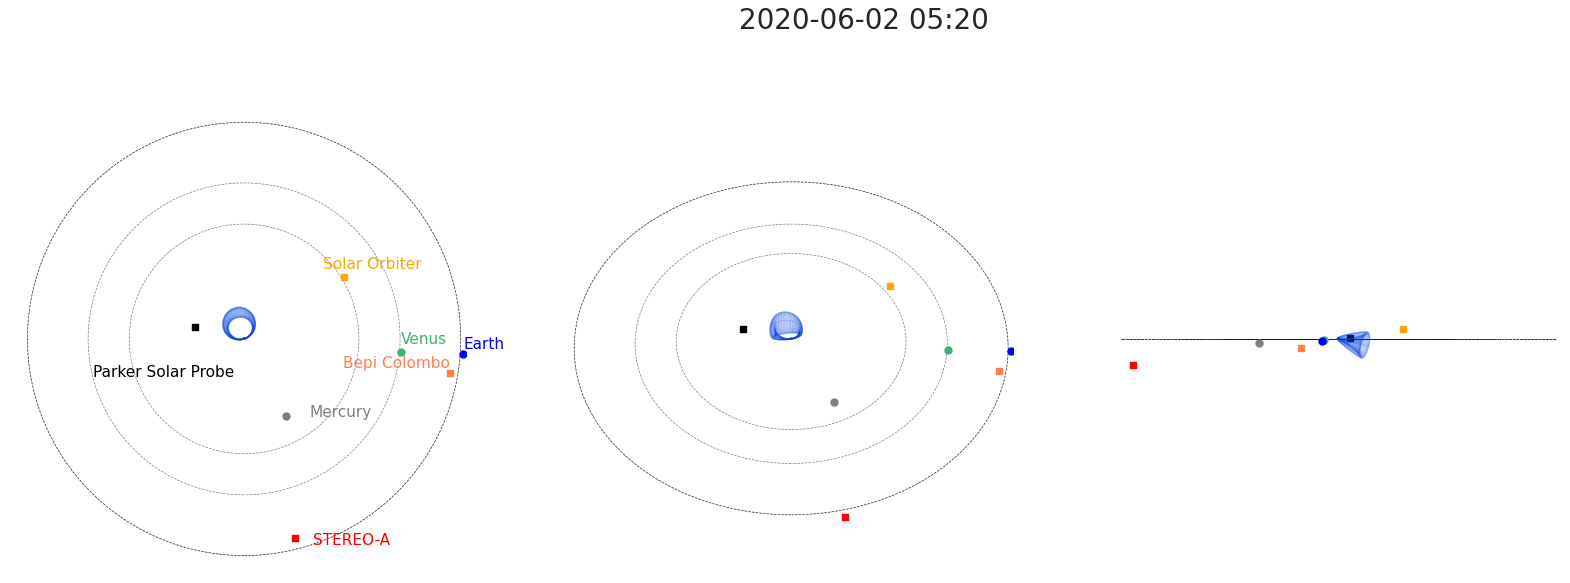

In [20]:
################## make animation    

#time for the animation as list
tlist=[]
for i in np.arange(0,24*8*60,20):    
    tlist.append(t_launch+datetime.timedelta(minutes=float(i)))
    
print('number of frames',len(tlist))
#sns.set_style('whitegrid')


#simulation time since launch
frametime=np.round((parse_time(tlist).plot_date-parse_time(t_launch).plot_date)*24,2)

#clock computing time
starttime1=time.time()

################################## single
#make test frames
#for k in np.arange(0,10):#len(tlist)):


#for field line plots stepsize and initial point for drawing    
field_stepsize=0.001   
q1=np.array([0.95, .2, np.pi/2-0.01])

k=10
make_frame(k)

In [21]:
############################## multi
#number of processes depends on your machines memory; check with command line "top"
#how much memory is used by all your processesii
nr_of_processes_used=100
print('Using multiprocessing, nr of cores',multiprocessing.cpu_count(), \
      'with nr of processes used: ',nr_of_processes_used)

#run multiprocessing pool to make all movie frames, depending only on frame number
pool = multiprocessing.Pool(processes=nr_of_processes_used)
input=[i for i in range(len(tlist))]
pool.map(make_frame, input)
pool.close()
#pool.join()

In [26]:
#quality is b ... k
os.system('ffmpeg -r 30 -i '+animdirectory+'/3dcore_solo_%05d.jpg -b 2500k -r 30 results/telloni_2021/anim_3dcore_solo_june7.mp4 -y -loglevel quiet')

#print('movie finished in',np.round((time.time()-starttime1)/60,2),' minutes')  
 

0